# Current Testing Battery

In [1]:
import sys
import statistics
import numpy
from itertools import product
from timeit import default_timer as timer
from tqdm import tqdm
sys.path.append("..")
import gillespy2
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
from gillespy2.basic_ssa_solver import BasicSSASolver
from gillespy2.ssa_c_solver import SSACSolver
from gillespy2.basic_root_solver import BasicRootSolver
from gillespy2.optimized_ssa_solver import OptimizedSSASolver
from gillespy2.basic_tau_leaping_solver import BasicTauLeapingSolver
from gillespy2.basic_tau_hybrid_solver import BasicTauHybridSolver
from gillespy2.example_models import *

In [3]:
import os
os.environ['STOCHKIT_HOME'] = "/mnt/c/Users/seanm/OneDrive/Documents/Research/StochKit"

In [4]:
def __get_results(solver, model, number_of_trajectories):
    results = []
    for i in tqdm(range(number_of_trajectories), desc='Model: {0}, Solver: {1}'.format(model.name, solver.name)):
        result = model.run(solver=solver)
        if isinstance(result, dict):
            results.append(result)
        else:
            results.append(result[0])
    return results

In [5]:
def create_distribution(solver, model, number_of_trajectories):
    results = __get_results(solver, model, number_of_trajectories)
    distribution = {}
    for trajectory in results:
        for species in trajectory.keys():
            distribution[species] = []
            for timestep in range(len(trajectory[species])):
                distribution[species].append([])
    trajectory_number = 0
    for trajectory in results:
            for species in trajectory.keys():
                for timestep in range(len(trajectory[species])):
                    distribution[species][timestep].append(trajectory[species][timestep])
            
    return distribution    

In [6]:
def get_stats(solver, standard_results, model, number_of_trajectories):
    interior_stats = {}
    test_results = create_distribution(solver, model, number_of_trajectories)          
    for species in test_results:
        interior_stats[species] = []
    for species in test_results:
        for timestep, value in enumerate(test_results[species]):
            interior_stats[species].append(stats.ks_2samp(value, standard_results[species][timestep]))
    return interior_stats

In [7]:
standard_results = {}
ks_stats = {}

number_of_trajectories = 50

solver_list = [BasicSSASolver(), BasicTauLeapingSolver(), BasicTauHybridSolver()]
model_list = [Example(), MichaelisMenten()]

for model in model_list:
    standard_results[model.name] = []
    ks_stats[model.name] = {}
    
for model in model_list:
    standard_results[model.name] = create_distribution(StochKitSolver, model, number_of_trajectories)
    for solver in solver_list:
        ks_stats[model.name][solver] = get_stats(solver, standard_results[model.name], model, number_of_trajectories)

Model: Michaelis_Menten, Solver: BasicSSASolver: 100%|██████████| 50/50 [00:09<00:00,  4.76it/s]
Model: Michaelis_Menten, Solver: Basic Tau Leaping Solver: 100%|██████████| 50/50 [00:18<00:00,  2.76it/s]
Model: Michaelis_Menten, Solver: Basic Tau Hybrid Solver: 100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


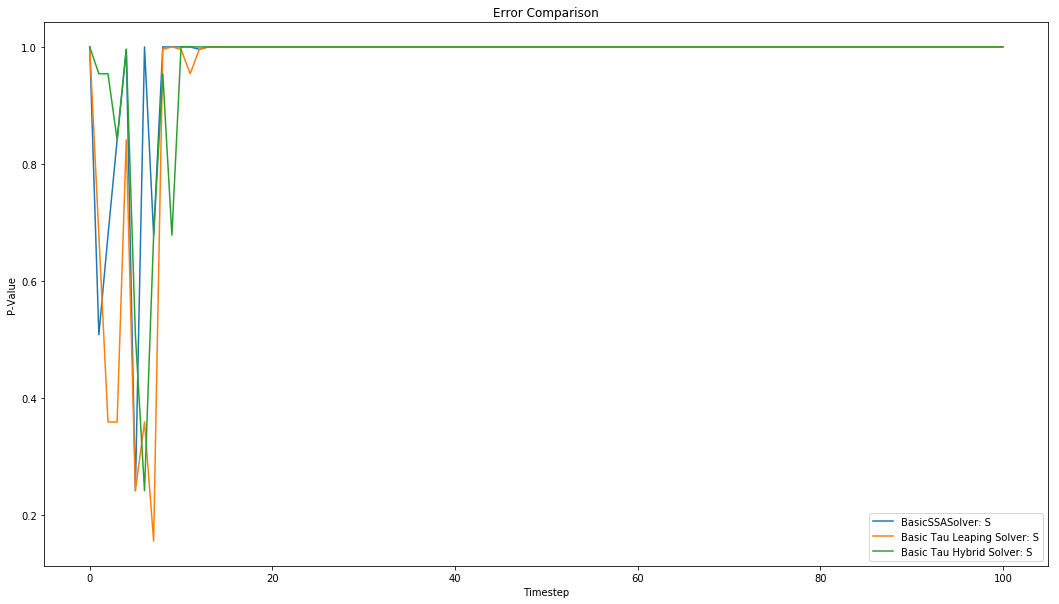

In [62]:
plt.figure(figsize=(18,10))
plt.title("Error Comparison")
plt.xlabel("Timestep")
plt.ylabel("P-Value")

for solver in solver_list:
    timesteps = []
    p_values = []
    for species in ks_stats[model_list[0].name][solver]:
        if species is not 'time':            
            
            result = ks_stats[model_list[0].name][solver][species][:]
            for timestep, value in enumerate(result):
                timesteps.append(timestep)
                ks, pv = value
                p_values.append(pv)
            plt.plot(timesteps, p_values, label='{0}: {1}'.format(solver.name, species))
plt.legend(loc='best')
            
#             plt.plot(range(len(ks_stats[model_list[0].name][solver][species])), ks_stats[model_list[0].name][solver][species][:], label=solver.name)
# plt.legend(loc='best')
# for solver in solver_list:
#     print('Using Solver: ', solver.name)
#     for species in ks_stats[model_list[0].name][solver]:
#         if species is not 'time':
#             print('Species: ', species)
#             for timestep, timestep_result in enumerate(ks_stats[model_list[0].name][solver][species]):
#                 print('Timestep ', timestep, ': P-Value: ', timestep_result[1])
#                 plt.plot(timestep, timestep_result[1], label=species)
    

# 1) GET BASIC ODE SOLVER WORKING
# 2) COMPLETE TESTING
# 3)